In [128]:
# Add needed libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import pickle

# Preprocessing
from sklearn.preprocessing import OneHotEncoder

# VIF for multi-collinearity detection
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Models and modeling tools
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.metrics import f1_score, balanced_accuracy_score

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# Change inline plots default size
plt.rcParams['figure.figsize'] = [14, 10]

## Data description: ##
The data comes from direct marketing efforts of a European banking institution. The marketing campaign involves making a phone call to a customer, often multiple times to ensure a product subscription, in this case a term deposit. Term deposits are usually short-term deposits with maturities ranging from one month to a few years. The customer must understand when buying a term deposit that they can withdraw their funds only after the term ends. All customer information that might reveal personal information is removed due to privacy concerns.

- y = has the client subscribed to a term deposit? (binary)
- age = age of customer (numeric)
- job = type of job (categorical)
- marital = marital status (categorical)
- education = education level (categorical)
- default = has credit in default (binary)
- balance = average yearly balance, in euros (numeric)
- housing = has a housing loan? (binary)
- loan = has personal loan? (binary)
- contact = contact communication type (categorical)
- day = last contact day of the month (numeric)
- month = last contact month of year (categorical)
- duration = last contact duration, in seconds (numeric)
- campaign = number of contacts performed during this campaign and for this client (numeric, includes last contact)

## Analysis Summary: ##

#### Goal(s): ####

Predict if the customer will subscribe (yes/no) to a term deposit contract (variable y)

#### Bonus(es): ####

We are also interested in finding customers who are more likely to buy the investment product. Determine the segment(s) of customers our client should prioritize.

What makes the customers buy? Tell us which feature we should be focusing more on.

<font size="3" >
    
#### Background ####
    
Some demographic information, financial status and call center interaction data was collected for customers during a direct marketing campaign selling term deposits to clients at a European bank. The data was used to develop a model to predict whether a customer will subscribe to the term deposit. Naturally, the typical subscription success rate is low (only 7.2% in the provided dataset), so the model must balance the tradeoff between losing possible subscriptions and producing false leads.
    
#### Demographic and Financial Model ####
    
Logistic Regression models were built for three different subsets of the data. The first model used only demographic and financial information, reflecting analysis that could be performed before a sales strategy was developed or initiated. The demographic/financials model was developed based on the following criteria:

    - If they had a housing and/or personal loan
    - If they are married
    - If they were between the ages of 30 and 60
    - If they had less than $1000 in their account
    - If they were a housemaid or in the services industry
    
The demographic/financials model maintained 70\% accuracy across cross-validation during the model building process and had 64\% accuracy on a held out subset of the data used to evaluate the final demographic/financials model.  More importantly, the model was built to prioritize identifying likely term deposit subscribers at the expense of additional false leads.  Potential subscribers are identified with a success rate above 10\% with more than 50\% of the term deposit subscribers being captured by the model. This model was prioritized to maximize the balance between these rates, with a bias towards increasing the number of term deposit subscribers captured where possible. Depending on subscription targets and sales employee schedules, the model could be adjusted to change these priorities.
    
#### Demographics, Financials and Contact Model ####

Next, we look to enhance the model with contact information, which could be used in sales campaign development to identify best strategies for how to reach out to prospective customers.  This model was based on:

    - If they had a housing and/or personal loan
    - If they are married
    - If they were between the ages of 30 and 60
    - If they were contacted in January, July, August or November
    - If it was known how they were contacted
    - If they were a blue-collar worker

In essence, considerations of the balance in their account were dropped in exchange for some information about the contact month or whether the data on whether they were contacted was missing.  An unknown contact type (telephone vs cellular) was present in over 30\% of the data, with a significantly different conversion rate (3.9\% vs 7.2\% telephone and 9.0\% cellular). There are plausible reasons for this relationship that could be inferred but do to the high frequency of missing data and significant relationship with the success of selling a term deposit, it would be beneficial to invest time and resources to identify this information in future collection efforts.

The demographic/financial/contact model improved accuracy to 77\% in the cross-validation effort and 67\% on the held out subset of data.  In addition, with the extra contact information, potential subscribers are identified with an approx 12\% success rate with almost 53\% of term deposit subscribers being captured by the model.

The model suggests a poor relationship between sales of term deposit contracts and the included months (Jan, Jul, Aug, Nov), suggesting that campaigns that run primarily in the summer months (Jul, Aug) or winter months (Nov, Jan) may be less successful than those run in the fall or spring.  The full dataset suggested very high conversion rates in March and October, but these may be anomalous due to very low proportions of that data in the full dataset.  Since the model did not identify them as significant, if additional funding is available, it may be useful to work to identify if those spikes in success rates are significant for those months.

The day of the month the customer was contacted also showed spikes in the raw data on the last day of the month (30/31) and first day of the month (1).  Alternate models with these flags included performed similarly to the chosen model, suggesting there may be some success to focusing contact efforts at the very end/very beginning of the month.  These datapoints also suffer from low frequencies in the data and would benefit from additional data focused on better understanding the relationship with customer purchases.

#### Full Dataset Model ####

Finally, we use all the data provided to build an enhanced model. The additional fields, `duration` and `campaign` contain information about interactions with the client during the sales campaign and thus do not provide information that can be used to initially select customers or design the sales campaign.  However, they can provide insight into rules of thumb for client interaction and guidance for the sales staff.  The full dataset model used information on:

    - How long was the last call with the customer
    - If they are married
    - How old they were
    - If they were contacted in January, March or October
    - If it was known how they were contacted
    
The path to building this model took a very different trajectory than the prior two models, with the longer the length of the final call with the customer being a very strong predictor of if that customer subscribed for a term deposit.  This makes sense as a call that results in a subscription will require more time on average than a call where the customer is not interested.  With this in the model, flags such as if the call was made in Oct or Mar, with very small sample sizes were able to contribute to the model, where previously their small proportions in the dataset seemed to limit their inclusion in the model.  

The full dataset model improved all the metrics significantly with accuracy over 87\% in both cross-validation and in the withheld test subset of data.  With the inclusion of the length of the final call, potential subscribers are identified at almost a 1 in 3 rate while the model correctly identifies about 2 in 3 of the subscribers.

Duration has a positive relationship with a successful subscription, suggesting the longer the sales team is on the call with a potential client, the more likely they are to succeed in a sale.  By examining the distribution of 
final call lengths, a general target of around 11.5 minutes is needed to achieve a 50\% success rate in completing a sale.  This would be a good target passed on to the sales team.

## Exploratory Data Analysis ##

In [778]:
# Read in the rawData
rawData = pd.read_csv('term-deposit-marketing-2020.csv')

# Separate data in independent (features) and dependent (target) datasets
features = rawData.copy()
target = features.pop('y')

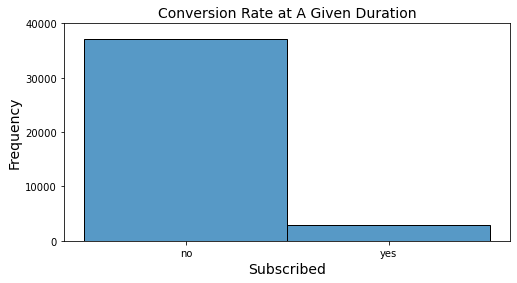

no     0.9276
yes    0.0724
Name: y, dtype: float64

In [787]:
# Plot response variable
plt.rcParams['figure.figsize'] = [8, 4]
fig, axs = plt.subplots()
ax = sns.histplot(data=rawData, x='y',discrete=True)
ax.set_xlabel('Subscribed', fontsize=14)
ax.set_ylabel('Frequency', fontsize=14)
ax.set_yticks([0, 10000, 20000, 30000, 40000])
ax.set_title('Conversion Rate at A Given Duration', fontsize=14)
plt.show()

# Get unbalanced ratios
target.value_counts() / target.count()

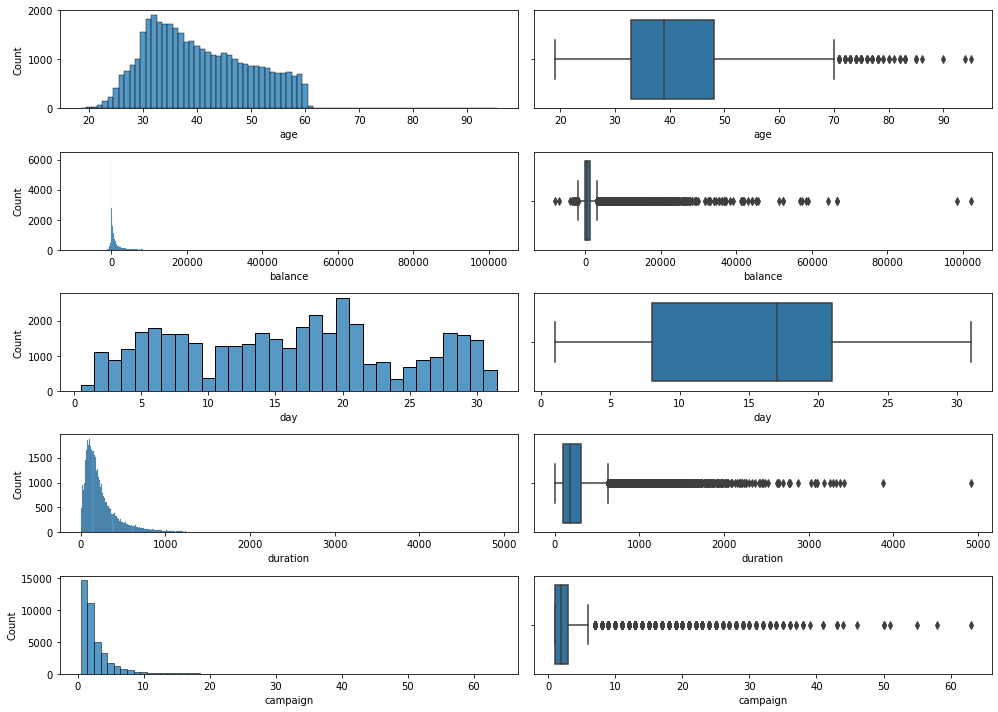

In [797]:
# Plot the feature distributions to look for skewed data/visualize possible outliers
plt.rcParams['figure.figsize'] = [14, 10]

intCols = np.where(features.dtypes == 'int64')

fig, axs = plt.subplots(np.size(intCols),2)
cnt = 0
for colID in intCols[0]:
    rnge = features[features.columns[colID]].max() - features[features.columns[colID]].min()
    if (rnge < 100):
        sns.histplot(data=features, x=features.columns[colID], ax=axs[cnt,0], discrete=True)
    else:
        sns.histplot(data=features, x=features.columns[colID], ax=axs[cnt,0])
    sns.boxplot(data=features, x=features.columns[colID], ax=axs[cnt,1])
    cnt = cnt + 1

plt.tight_layout()
plt.show()

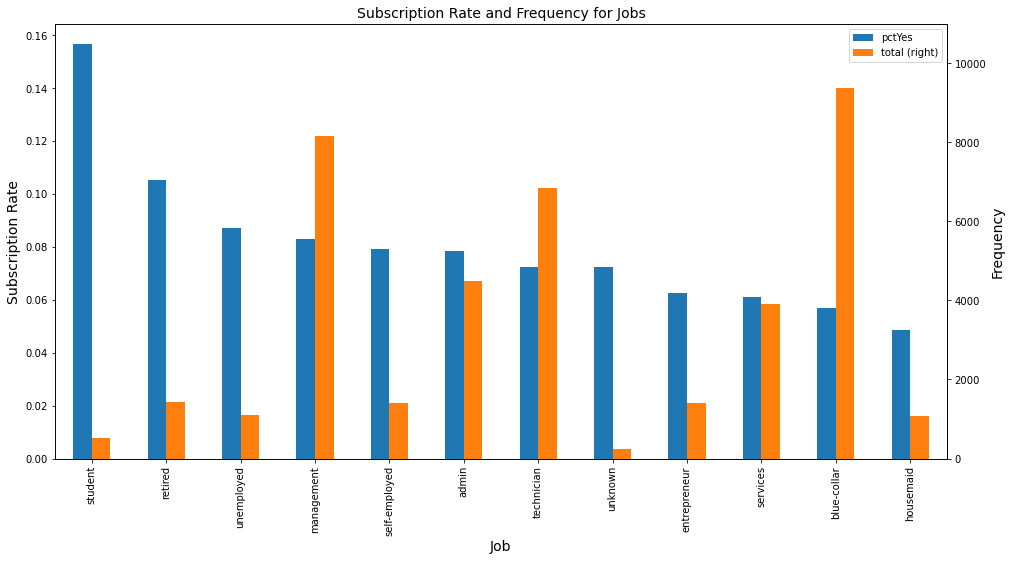

In [861]:
plt.rcParams['figure.figsize'] = [16, 8]
var = 'job'

grouped = rawData.groupby(by=['y',var]).count()['age']
yes = grouped.loc['yes']
no = grouped.loc['no']
binned = pd.concat([yes / (yes + no), yes + no], axis=1)
binned.columns=['pctYes','total']
ax = binned.sort_values(by='pctYes', ascending=False).plot(kind='bar', y=['pctYes','total'], secondary_y=['total'])
ax.set(xlabel = 'Job', ylabel = 'Subscription Rate')
ax.xaxis.label.set_fontsize(14)
ax.yaxis.label.set_fontsize(14)
plt.ylim([0,11000])
plt.ylabel('Frequency', fontsize=14)
plt.title('Subscription Rate and Frequency for Jobs', fontsize=14)
plt.show()

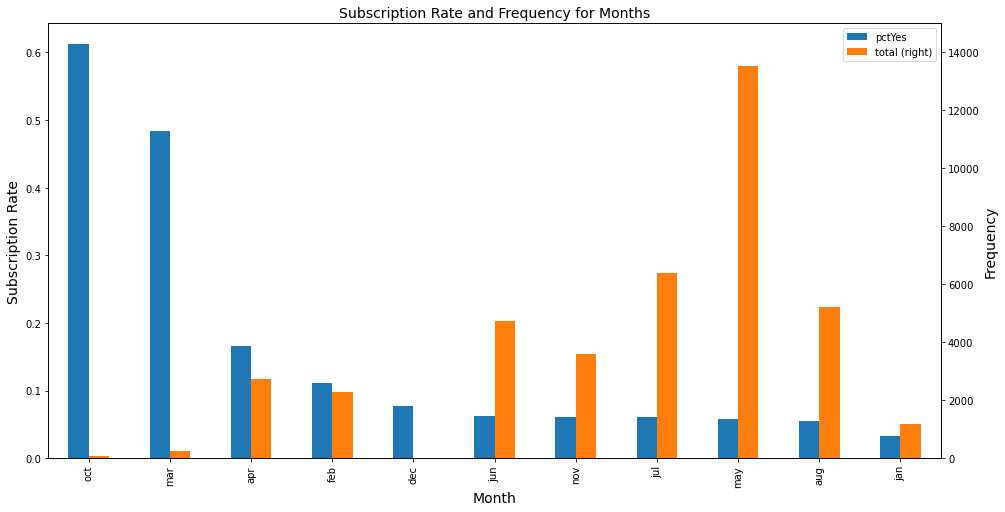

In [872]:
plt.rcParams['figure.figsize'] = [16, 8]
var = 'month'

grouped = rawData.groupby(by=['y',var]).count()['age']
yes = grouped.loc['yes']
no = grouped.loc['no']
binned = pd.concat([yes / (yes + no), yes + no], axis=1)
binned.columns=['pctYes','total']
ax = binned.sort_values(by='pctYes', ascending=False).plot(kind='bar', y=['pctYes','total'], secondary_y=['total'])
ax.set(xlabel = 'Month', ylabel = 'Subscription Rate')
ax.xaxis.label.set_fontsize(14)
ax.yaxis.label.set_fontsize(14)
plt.ylim([0,15000])
plt.ylabel('Frequency', fontsize=14)
plt.title('Subscription Rate and Frequency for Months', fontsize=14)
plt.show()

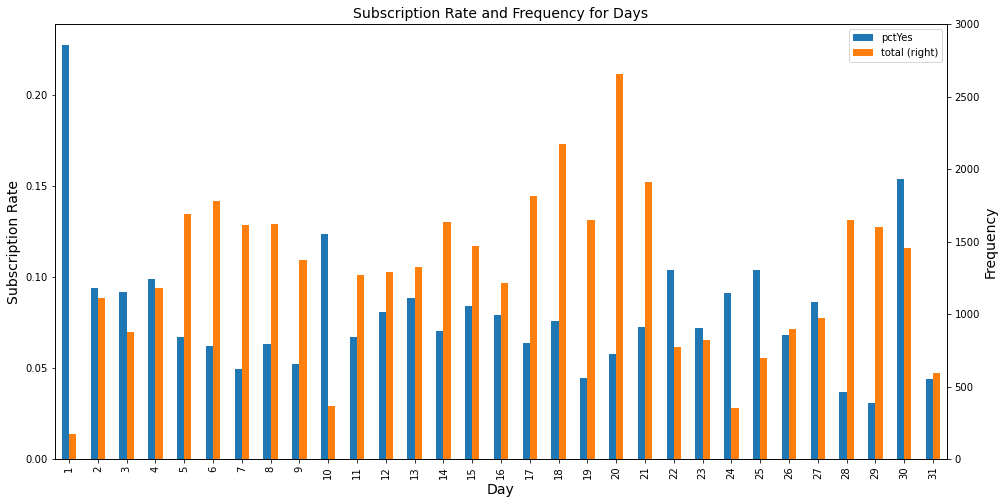

In [867]:
plt.rcParams['figure.figsize'] = [16, 8]
var = 'day'

grouped = rawData.groupby(by=['y',var]).count()['age']
yes = grouped.loc['yes']
no = grouped.loc['no']
binned = pd.concat([yes / (yes + no), yes + no], axis=1)
binned.columns=['pctYes','total']
ax = binned.plot(kind='bar', y=['pctYes','total'], secondary_y=['total'])
ax.set(xlabel = 'Day', ylabel = 'Subscription Rate')
ax.xaxis.label.set_fontsize(14)
ax.yaxis.label.set_fontsize(14)
plt.ylim([0,3000])
plt.ylabel('Frequency', fontsize=14)
plt.title('Subscription Rate and Frequency for Days', fontsize=14)
plt.show()

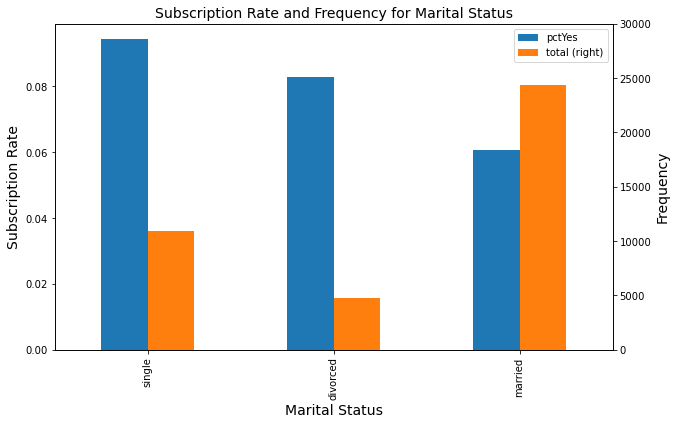

In [878]:
plt.rcParams['figure.figsize'] = [10, 6]
var = 'marital'

grouped = rawData.groupby(by=['y',var]).count()['age']
yes = grouped.loc['yes']
no = grouped.loc['no']
binned = pd.concat([yes / (yes + no), yes + no], axis=1)
binned.columns=['pctYes','total']
ax = binned.sort_values(by='pctYes', ascending=False).plot(kind='bar', y=['pctYes','total'], secondary_y=['total'])
ax.set(xlabel = 'Marital Status', ylabel = 'Subscription Rate')
ax.xaxis.label.set_fontsize(14)
ax.yaxis.label.set_fontsize(14)
plt.ylim([0,30000])
plt.ylabel('Frequency', fontsize=14)
plt.title('Subscription Rate and Frequency for Marital Status', fontsize=14)
plt.show()

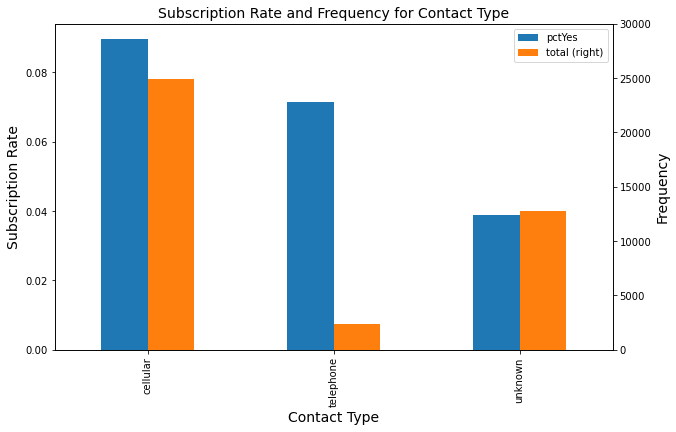

In [879]:
plt.rcParams['figure.figsize'] = [10, 6]
var = 'contact'

grouped = rawData.groupby(by=['y',var]).count()['age']
yes = grouped.loc['yes']
no = grouped.loc['no']
binned = pd.concat([yes / (yes + no), yes + no], axis=1)
binned.columns=['pctYes','total']
ax = binned.sort_values(by='pctYes', ascending=False).plot(kind='bar', y=['pctYes','total'], secondary_y=['total'])
ax.set(xlabel = 'Contact Type', ylabel = 'Subscription Rate')
ax.xaxis.label.set_fontsize(14)
ax.yaxis.label.set_fontsize(14)
plt.ylim([0,30000])
plt.ylabel('Frequency', fontsize=14)
plt.title('Subscription Rate and Frequency for Contact Type', fontsize=14)
plt.show()

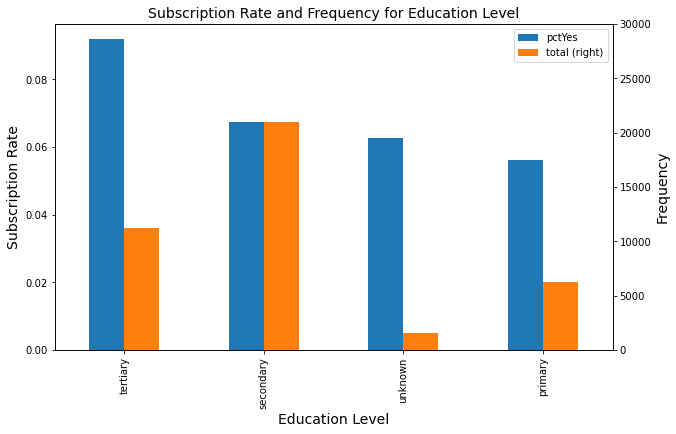

In [880]:
plt.rcParams['figure.figsize'] = [10, 6]
var = 'education'

grouped = rawData.groupby(by=['y',var]).count()['age']
yes = grouped.loc['yes']
no = grouped.loc['no']
binned = pd.concat([yes / (yes + no), yes + no], axis=1)
binned.columns=['pctYes','total']
ax = binned.sort_values(by='pctYes', ascending=False).plot(kind='bar', y=['pctYes','total'], secondary_y=['total'])
ax.set(xlabel = 'Education Level', ylabel = 'Subscription Rate')
ax.xaxis.label.set_fontsize(14)
ax.yaxis.label.set_fontsize(14)
plt.ylim([0,30000])
plt.ylabel('Frequency', fontsize=14)
plt.title('Subscription Rate and Frequency for Education Level', fontsize=14)
plt.show()

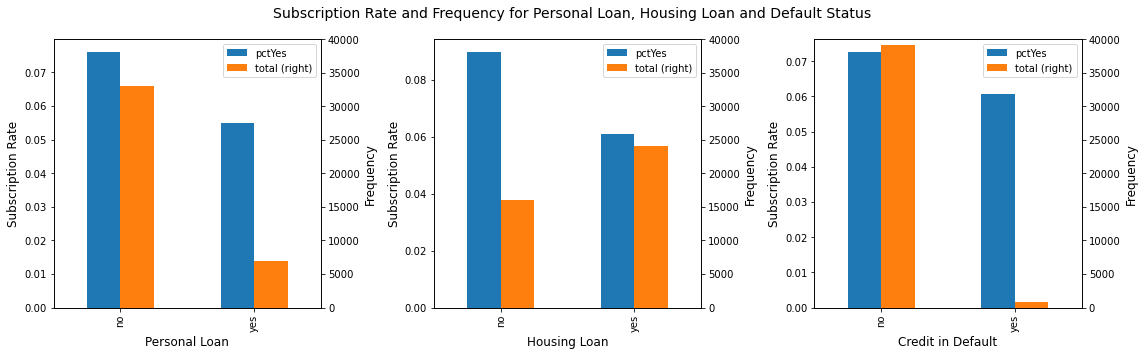

In [903]:
# Plot the feature distributions to look for skewed data/visualize possible outliers
plt.rcParams['figure.figsize'] = [16, 5]

fig, axs = plt.subplots(1,3)

var = 'loan'
grouped = rawData.groupby(by=['y',var]).count()['age']
yes = grouped.loc['yes']
no = grouped.loc['no']
binned = pd.concat([yes / (yes + no), yes + no], axis=1)
binned.columns=['pctYes','total']
ax = binned.sort_values(by='pctYes', ascending=False).plot(kind='bar', y=['pctYes','total'], secondary_y=['total'], ax=axs[0])
ax.set(xlabel = 'Personal Loan', ylabel = 'Subscription Rate')
ax.xaxis.label.set_fontsize(12)
ax.yaxis.label.set_fontsize(12)
plt.ylim([0,40000])
plt.ylabel('Frequency', fontsize=12)
#plt.title('Subscription Rate and Frequency for Personal Loan Status', fontsize=14)

var = 'housing'
grouped = rawData.groupby(by=['y',var]).count()['age']
yes = grouped.loc['yes']
no = grouped.loc['no']
binned = pd.concat([yes / (yes + no), yes + no], axis=1)
binned.columns=['pctYes','total']
ax = binned.sort_values(by='pctYes', ascending=False).plot(kind='bar', y=['pctYes','total'], secondary_y=['total'], ax=axs[1])
ax.set(xlabel = 'Housing Loan', ylabel = 'Subscription Rate')
ax.xaxis.label.set_fontsize(12)
ax.yaxis.label.set_fontsize(12)
plt.ylim([0,40000])
plt.ylabel('Frequency', fontsize=12)
#plt.title('Subscription Rate and Frequency for Housing Loan Status', fontsize=14)

var = 'default'
grouped = rawData.groupby(by=['y',var]).count()['age']
yes = grouped.loc['yes']
no = grouped.loc['no']
binned = pd.concat([yes / (yes + no), yes + no], axis=1)
binned.columns=['pctYes','total']
ax = binned.sort_values(by='pctYes', ascending=False).plot(kind='bar', y=['pctYes','total'], secondary_y=['total'], ax=axs[2])
ax.set(xlabel = 'Credit in Default', ylabel = 'Subscription Rate')
ax.xaxis.label.set_fontsize(12)
ax.yaxis.label.set_fontsize(12)
plt.ylim([0,40000])
plt.ylabel('Frequency', fontsize=12)
plt.suptitle('Subscription Rate and Frequency for Personal Loan, Housing Loan and Default Status', fontsize=14)
plt.tight_layout()
plt.show()

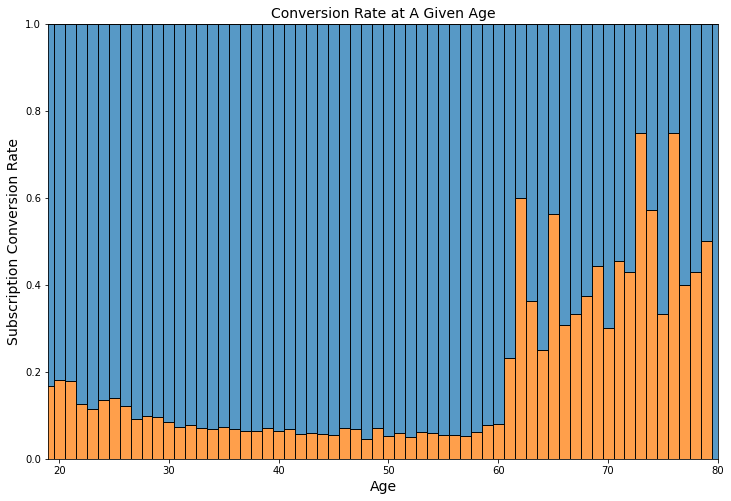

In [805]:
plt.rcParams['figure.figsize'] = [12, 8]
ax = sns.histplot(data=rawData, x='age', hue='y', discrete=True, multiple='fill')
ax.set_xlabel('Age', fontsize=14)
ax.set_xlim([19,80])
ax.set_ylim([0,1.0])
ax.set_ylabel('Subscription Conversion Rate', fontsize=14)
ax.set_title('Conversion Rate at A Given Age', fontsize=14)
ax.get_legend().remove()
plt.show()

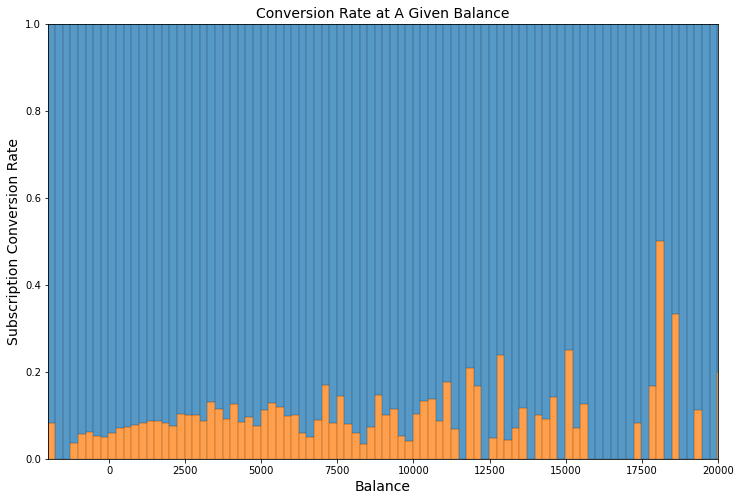

In [811]:
plt.rcParams['figure.figsize'] = [12, 8]
ax = sns.histplot(data=rawData, x='balance', hue='y', binwidth=250, multiple='fill')
ax.set_xlabel('Balance', fontsize=14)
ax.set_xlim([-2000,20000])
ax.set_ylim([0,1.0])
ax.set_ylabel('Subscription Conversion Rate', fontsize=14)
ax.set_title('Conversion Rate at A Given Balance', fontsize=14)
ax.get_legend().remove()
plt.show()

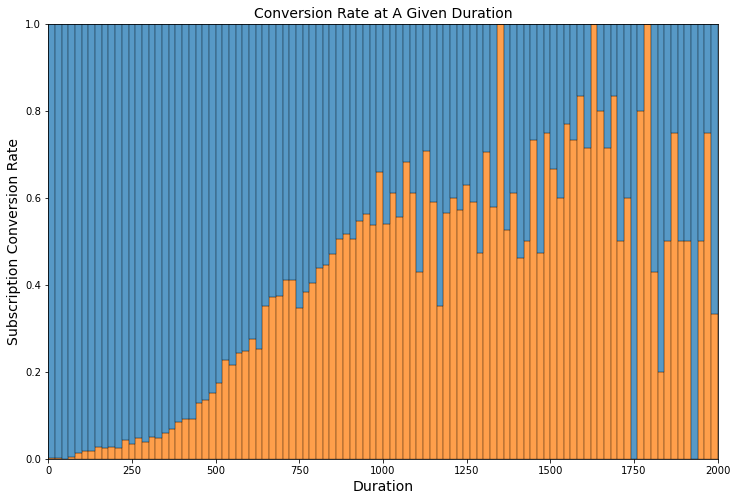

In [806]:
plt.rcParams['figure.figsize'] = [12, 8]
ax = sns.histplot(data=rawData, x='duration', hue='y', binwidth=20, multiple='fill')
ax.set_xlabel('Duration', fontsize=14)
ax.set_xlim([0,2000])
ax.set_ylim([0,1.0])
ax.set_ylabel('Subscription Conversion Rate', fontsize=14)
ax.set_title('Conversion Rate at A Given Duration', fontsize=14)
ax.get_legend().remove()
plt.show()

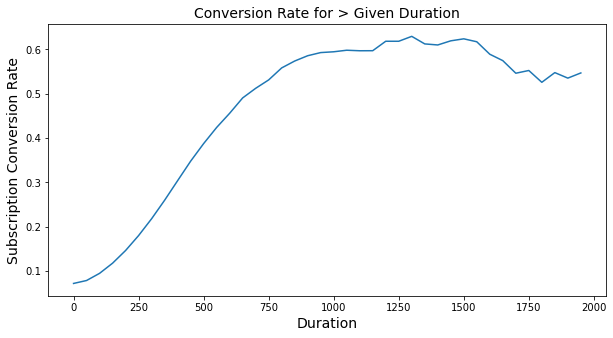

In [796]:
### Converting subscribers larger than various durations
arr = []
for i in range(0,2000,50):
    yval = rawData.loc[rawData.duration > i]['y'].value_counts(normalize=True)['yes']
    arr.append([i, yval])
    
plt.rcParams['figure.figsize'] = [10, 5]
ax = sns.lineplot(x=np.asarray(arr)[:, 0], y=np.asarray(arr)[:, 1])
ax.set_xlabel('Duration', fontsize=14)
ax.set_ylabel('Subscription Conversion Rate', fontsize=14)
ax.set_title('Conversion Rate for > Given Duration', fontsize=14)
plt.show()

### EDA Summary: 
- __Unbalanced Binary response variable__ 
    - Oversampling with SMOTE will probably be important
- __Mix of categorical and quantitative__ 
    - Will need to encode the categorical variables and assess the quantitative ones for normalization/scaling
- __Outliers in continuous data, low frequency categories__
    - Will need to address lots of outliers, small frequency categories 
    - Binning may be a good strategy for quantitative features 
    - Try building model with and without small frequency categories, keep close eye on p-values
- __Age__
    - Seems to be some improved success rate for those <25 and older than 60, but small sample sizes so need to be careful
- __Duration__
    - Seems to have a strong relationship with subscription, especially after a few hundred seconds
- __Contact__
    - Significant number of `Unknown` with a clear bias in those missing values
- __Balance__
    - Maybe a small uptick in subscription rate for high balances, but may be hard to extract a useful signal
- __Housing Loan__
    - There may be a slight significant relationship here, but may not be easily extracted
- __Month__
    - Oct and Mar significant success rate, but extremely low frequency, will need to be careful about models using these columns for significant p-values and convergence success
    - No Sept data and a very small amount of Dec data
- __Days__
    - End of month (30/31) and Beginning of month (1st) show a strong success signal relative to rest of month
    - Low frequency of successful columns

## Demographics/Financials Model ##

### Preprocess data ###

In [274]:
# Read in the rawData
rawData = pd.read_csv('term-deposit-marketing-2020.csv')

# Separate data in independent (features) and dependent (target) datasets
features = rawData[['age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'y']].copy()
target = features.pop('y')

# Replace target 'yes'/'no' with 1/0
target.replace({'yes':1,'no':0}, inplace=True)

# Split data initially to form a validation and test dataset
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.10, random_state=10)

# Reset index after train_test_split
x_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
x_test.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

In [275]:
# Replace binary columns with 1/0 and One-Hot Encode categorical columns
cols = ['default', 'housing', 'loan', 'marital', 'education', 'job']
enc = OneHotEncoder(sparse=False, dtype=int, handle_unknown='error', drop='if_binary')
encodedTrain = enc.fit_transform(x_train[cols]) # Fit only on the training data
encodedTest = enc.transform(x_test[cols])

# Construct encoded names for One-Hot columns
encNames = enc.get_feature_names()
for index, item in enumerate(encNames):
    tmp = item.split('_')[0].split('x')[1]
    if (item.split('_')[1] == 'yes'):
        encNames[index] = encNames[index].replace('x' + tmp + '_yes', cols[int(tmp)])
    else:
        encNames[index] = encNames[index].replace('x' + tmp, cols[int(tmp)])

encodedTrain = pd.DataFrame(encodedTrain, columns=encNames)
encodedTest = pd.DataFrame(encodedTest, columns=encNames)

# Merge encoded columns back into the dataset
x_train = x_train.drop(columns=cols)
x_train = pd.concat([x_train, encodedTrain], axis=1)
x_test = x_test.drop(columns=cols)
x_test = pd.concat([x_test, encodedTest], axis=1)

In [277]:
# Bin age to deal with outliers/group similar ranges 
for dataset in [x_train, x_test, x_train_ov]:    
    dataset['<30'] = (dataset['age'] < 30).replace({True:1,False:0})
    dataset['30-60'] = ((dataset['age'] >= 30) & (dataset['age'] < 61)).replace({True:1,False:0})
    dataset['61+'] = (dataset['age'] >= 61).replace({True:1,False:0})
      
# Bin balance to deal with outliers/group similar ranges
for dataset in [x_train, x_test, x_train_ov]:    
    dataset['<1000'] = (dataset['balance'] < 1000).replace({True:1,False:0})
    dataset['1000-20000'] = ((dataset['balance'] >= 1000) & (dataset['age'] < 20000)).replace({True:1,False:0})
    dataset['>20000'] = (dataset['balance'] >= 20000).replace({True:1,False:0})

### Build Up Model ###

In [368]:
# Create 5 k-folds for model evaluation
kf = KFold(n_splits=5, random_state=30, shuffle=True)

# Add constants to the dataset (needed in statsmodels package)
x_train = sm.add_constant(x_train)

# Create a list to append models evaluation to
summaryTab = []

# Build-up model process, test each indep variable against response,
# choose best performing (ad-hoc process using combination of low AIC/BIC, 
# p-value and validation set scoring metrics)
# Then add that variable and repeat the process with the remaining variables
# Stop once the addition of extra variables doesn't add much to the solution (keep model simpler)
for col in x_train_ov:
    # features chosen in the final model
    useCols = ['const', 'marital_married', 'housing', '30-60', 'job_services', 
               'job_housemaid', '<1000', 'loan']
    # features that begin to have convergence issues as the model is developed
    skipCols = ['1000-20000'] 
    if (col in useCols): continue
    if (col in skipCols): continue
    #useCols.append(col)  ### comment this out when finished
    
    # Cross-validation loop
    cnt = 0
    for train_index, valid_index in kf.split(x_train):
        cur_x_train, cur_x_valid = x_train.iloc[train_index], x_train.iloc[valid_index]
        cur_y_train, cur_y_valid = y_train.iloc[train_index], y_train.iloc[valid_index]
        
        # Oversample the minority set in the training data
        oversample = SMOTE()
        x_train_ov, y_train_ov = oversample.fit_resample(cur_x_train, cur_y_train)
        
        # Train model
        logReg = sm.Logit(y_train_ov, x_train_ov[useCols])
        result = logReg.fit(disp=False)

        # Evaluate model on validation dataset
        y_pred = logReg.predict(result.params, exog=cur_x_valid[useCols])
    
        # Store model evaluation metrics to display below
        summaryTab.append([cnt, col, result.pvalues.max(), result.llf, result.aic, result.bic, 
                       recall_score(cur_y_valid,y_pred.round()),precision_score(cur_y_valid,y_pred.round()),
                       f1_score(cur_y_valid,y_pred.round()),accuracy_score(cur_y_valid,y_pred.round()),
                       balanced_accuracy_score(cur_y_valid,y_pred.round())])
        
        # Counter for fold number
        cnt = cnt + 1
        
    break   ### comment this in when finished to build final model
    
# Create summary table
tab = pd.DataFrame(summaryTab, columns=['fold', 'name', 'max_pvalue','llf', 'aic', 'bic', 'recall', 
                                        'precision', 'f1', 'accuracy', 'balanced accuracy'])

# Aggregate results across folds
aggs = {'llf': 'mean', 'max_pvalue': 'max', 'aic': 'mean', 'bic': 'mean', 'recall': 'mean', 
        'precision': 'mean', 'f1': 'mean', 'accuracy': 'mean', 'balanced accuracy': 'mean'}
tab = tab.groupby(by='name').agg(aggs)

# Display model evaluation results
tab.sort_values(by='f1', ascending=False)

/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:130: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,llf,max_pvalue,aic,bic,recall,precision,f1,accuracy,balanced accuracy
name,,,,,,,,,
age,-29628.314861,1.168330e-25,59272.629722,59343.720001,0.432397,0.106957,0.171024,0.6965,0.574752


In [466]:
# Build up model sequence summary (seq column tells order in which feature was added)
demogFinanModel = pickle.load(open('demoFinaModel.p','rb'))
demogFinanModel

,llf,max_pvalue,aic,bic,recall,precision,f1,accuracy,balanced accuracy,seq
marital_married,-34434.984184,0.000000e+00,68873.968367,68891.740937,0.491997,0.091091,0.153711,0.608472,0.554766,1.0
housing,-32199.143496,0.000000e+00,64404.286991,64430.945845,0.238897,0.110557,0.151134,0.806250,0.544656,2.0
job_services,-31184.091735,1.282110e-157,62378.183470,62422.614894,0.311968,0.114601,0.167606,0.776222,0.562164,4.0
30-60,-31810.314033,1.670610e-139,63628.628066,63664.173206,0.330004,0.111489,0.166647,0.761583,0.562589,3.0
job_housemaid,-30827.322601,2.727512e-72,61666.645203,61719.962912,0.306596,0.116264,0.168568,0.781611,0.562591,5.0
<1000,-30678.157565,4.036027e-50,61370.315129,61432.519123,0.453228,0.104867,0.170317,0.681028,0.575994,6.0
loan,-29673.228205,5.652163e-27,59362.456411,59433.546689,0.431644,0.107042,0.171059,0.697111,0.574735,7.0


### Evaluate model on test data ###

In [390]:
finalCols = ['const', 'marital_married', 'housing', '30-60', 'job_services', 'job_housemaid', '<1000', 'loan']

# Build final model
oversample = SMOTE()
x_train_ov, y_train_ov = oversample.fit_resample(x_train[finalCols], y_train)
logReg = sm.Logit(y_train_ov, x_train_ov)
result = logReg.fit(disp=False)

# Evaluate model on test dataset
x_test = sm.add_constant(x_test)
y_pred = logReg.predict(result.params, exog=x_test[finalCols])

print ('Recall:', recall_score(y_test,y_pred.round()))
print ('Precision:', precision_score(y_test,y_pred.round()))
print ('F1:', f1_score(y_test,y_pred.round()))
print ('Accuracy:', accuracy_score(y_test,y_pred.round()))

Recall: 0.5152542372881356
Precision: 0.10475534114403859
F1: 0.17411225658648338
Accuracy: 0.6395


/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:130: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


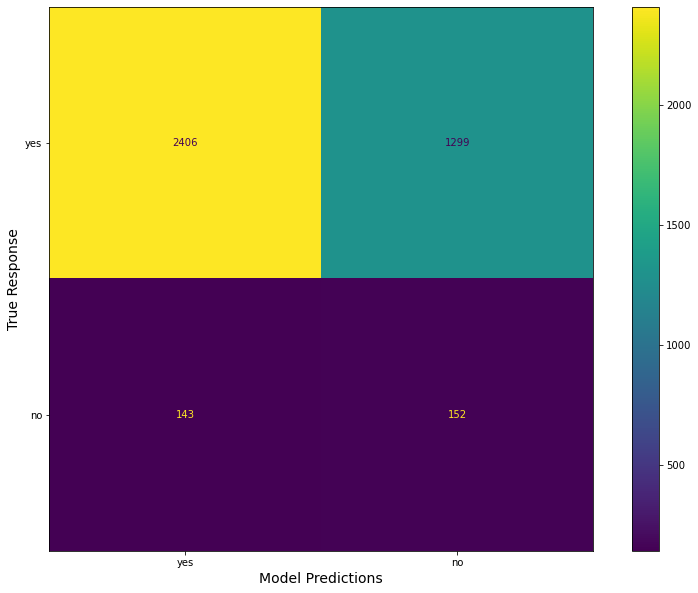

In [419]:
# Plot confusion matrix for test data
cm = confusion_matrix(y_test, y_pred.round())
ax = ConfusionMatrixDisplay(cm, display_labels=['yes','no']).plot()
ax.ax_.set_xlabel('Model Predictions', fontsize=14)
ax.ax_.set_ylabel('True Response', fontsize=14)
plt.show()

## Demographics/Financials/Contact Model ##

### Preprocess data ###

In [592]:
# Read in the rawData
rawData = pd.read_csv('term-deposit-marketing-2020.csv')

# Separate data in independent (features) and dependent (target) datasets
features = rawData[['age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 
                    'contact', 'day', 'month', 'y']].copy()
target = features.pop('y')

# Replace target 'yes'/'no' with 1/0
target.replace({'yes':1,'no':0}, inplace=True)

# Split data initially to form a validation and test dataset
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.10, random_state=100)

# Reset index after train_test_split
x_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
x_test.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

In [593]:
# Replace binary columns with 1/0 and One-Hot Encode categorical columns
cols = ['default', 'housing', 'loan', 'marital', 'education', 'job', 'contact', 'month', 'day']
enc = OneHotEncoder(sparse=False, dtype=int, handle_unknown='error', drop='if_binary')
encodedTrain = enc.fit_transform(x_train[cols]) # Fit only on the training data
encodedTest = enc.transform(x_test[cols])

# Construct encoded names for One-Hot columns
encNames = enc.get_feature_names()
for index, item in enumerate(encNames):
    tmp = item.split('_')[0].split('x')[1]
    if (item.split('_')[1] == 'yes'):
        encNames[index] = encNames[index].replace('x' + tmp + '_yes', cols[int(tmp)])
    else:
        encNames[index] = encNames[index].replace('x' + tmp, cols[int(tmp)])

encodedTrain = pd.DataFrame(encodedTrain, columns=encNames)
encodedTest = pd.DataFrame(encodedTest, columns=encNames)

# Merge encoded columns back into the dataset
x_train = x_train.drop(columns=cols)
x_train = pd.concat([x_train, encodedTrain], axis=1)
x_test = x_test.drop(columns=cols)
x_test = pd.concat([x_test, encodedTest], axis=1)

In [595]:
# Bin age to deal with outliers/group similar ranges 
for dataset in [x_train, x_test]:    
    dataset['<30'] = (dataset['age'] < 30).replace({True:1,False:0})
    dataset['30-60'] = ((dataset['age'] >= 30) & (dataset['age'] < 61)).replace({True:1,False:0})
    dataset['61+'] = (dataset['age'] >= 61).replace({True:1,False:0})

# Bin balance to deal with outliers/group similar ranges
for dataset in [x_train, x_test]:    
    dataset['<1000'] = (dataset['balance'] < 1000).replace({True:1,False:0})
    dataset['1000-20000'] = ((dataset['balance'] >= 1000) & (dataset['age'] < 20000)).replace({True:1,False:0})
    dataset['>20000'] = (dataset['balance'] >= 20000).replace({True:1,False:0})
    
# Bin day to deal with outliers/group similar ranges
#for dataset in [x_train, x_test]:    
#    dataset['BegMonth'] = (dataset['day'] < 5).replace({True:1,False:0})
#    dataset['MidMonth'] = ((dataset['day'] >= 5) & (dataset['day'] < 30)).replace({True:1,False:0})
#    dataset['LastDayMonth'] = (dataset['day'] >= 30).replace({True:1,False:0})

### Build Up Model ###

In [596]:
# Create 5 k-folds for model evaluation
kf = KFold(n_splits=5, random_state=30, shuffle=True)

# Add constants to the dataset (needed in statsmodels package)
x_train = sm.add_constant(x_train)

# Create a list to append models evaluation to
summaryTab = []

# Build-up model process, test each indep variable against response,
# choose best performing (ad-hoc process using combination of low AIC/BIC, 
# p-value and validation set scoring metrics)
# Then add that variable and repeat the process with the remaining variables
# Stop once the addition of extra variables doesn't add much to the solution (keep model simpler)
for col in x_train:
    # features chosen in the final model
    useCols = ['const', 'contact_unknown', 'marital_married', 'month_aug', 'housing', 'month_jul',
               'month_nov', 'job_blue-collar', 'month_jan', '30-60']
    # features that begin to have convergence issues as the model is developed
    skipCols = ['month_dec'] 
    if (col in useCols): continue
    if (col in skipCols): continue
    #useCols.append(col)  ### comment this out when finished
    
    # Cross-validation loop
    cnt = 0
    for train_index, valid_index in kf.split(x_train):
        cur_x_train, cur_x_valid = x_train.iloc[train_index], x_train.iloc[valid_index]
        cur_y_train, cur_y_valid = y_train.iloc[train_index], y_train.iloc[valid_index]
        
        # Oversample the minority set in the training data
        oversample = SMOTE()
        x_train_ov, y_train_ov = oversample.fit_resample(cur_x_train, cur_y_train)
        
        # Train model
        logReg = sm.Logit(y_train_ov, x_train_ov[useCols])
        result = logReg.fit(disp=False)

        # Evaluate model on validation dataset
        y_pred = logReg.predict(result.params, exog=cur_x_valid[useCols])
    
        # Store model evaluation metrics to display below
        summaryTab.append([cnt, col, result.pvalues.max(), result.llf, result.aic, result.bic, 
                       recall_score(cur_y_valid,y_pred.round()),precision_score(cur_y_valid,y_pred.round()),
                       f1_score(cur_y_valid,y_pred.round()),accuracy_score(cur_y_valid,y_pred.round()),
                       balanced_accuracy_score(cur_y_valid,y_pred.round())])
        
        # Counter for fold number
        cnt = cnt + 1
        
    break   ### comment this in when finished to build final model
    
# Create summary table
tab = pd.DataFrame(summaryTab, columns=['fold', 'name', 'max_pvalue','llf', 'aic', 'bic', 'recall', 
                                        'precision', 'f1', 'accuracy', 'balanced accuracy'])

# Aggregate results across folds
aggs = {'llf': 'mean', 'max_pvalue': 'max', 'aic': 'mean', 'bic': 'mean', 'recall': 'mean', 
        'precision': 'mean', 'f1': 'mean', 'accuracy': 'mean', 'balanced accuracy': 'mean'}
tab = tab.groupby(by='name').agg(aggs)

# Display model evaluation results
tab.sort_values(by='aic', ascending=True)

/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:130: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,llf,max_pvalue,aic,bic,recall,precision,f1,accuracy,balanced accuracy
name,,,,,,,,,
age,-21460.723921,1.575060e-12,42941.447842,43030.309492,0.466627,0.152258,0.229568,0.773583,0.632083


In [538]:
# Build up model sequence summary (seq column tells order in which feature was added)
demogFinanContModel = pickle.load(open('demoFinaContModel.p','rb'))
demogFinanContModel.sort_values(by='seq')

,llf,max_pvalue,aic,bic,recall,precision,f1,accuracy,balanced accuracy,seq
contact_unknown,-33046.693564,1.516519e-283,66097.387128,66115.159458,0.831885,0.088391,0.159791,0.366972,0.581299,1.0
marital_married,-30758.859288,0.000000e+00,61523.718575,61550.377070,0.408030,0.109543,0.172690,0.717306,0.574744,2.0
month_aug,-29110.725282,0.000000e+00,58229.450565,58264.995225,0.370174,0.117522,0.178363,0.753500,0.576808,3.0
housing,-27130.715376,0.000000e+00,54271.430751,54315.861576,0.541919,0.115419,0.190282,0.666417,0.609035,4.0
month_jul,-24824.836196,0.000000e+00,49661.672392,49714.989381,0.452725,0.135528,0.208569,0.751528,0.613785,5.0
month_nov,-23116.351165,0.000000e+00,46246.702330,46308.905484,0.403230,0.155629,0.224549,0.798611,0.616347,6.0
job_blue-collar,-22497.100071,2.441480e-193,45010.200142,45081.289462,0.416828,0.154877,0.224315,0.789778,0.617841,7.0
month_jan,-21398.353592,3.013828e-126,42814.707185,42894.682669,0.457009,0.152909,0.229125,0.777667,0.629849,8.0
30-60,-21350.510018,7.362367e-23,42721.020035,42809.881685,0.466992,0.151364,0.228595,0.772056,0.631426,9.0


### Evaluate model on test data ###

In [540]:
finalCols = ['const', 'contact_unknown', 'marital_married', 'month_aug', 'housing', 'month_jul',
            'month_nov', 'job_blue-collar', 'month_jan', '30-60']

# Build final model
oversample = SMOTE()
x_train_ov, y_train_ov = oversample.fit_resample(x_train[finalCols], y_train)
logReg = sm.Logit(y_train_ov, x_train_ov)
result = logReg.fit(disp=False)

# Evaluate model on test dataset
x_test = sm.add_constant(x_test)
y_pred = logReg.predict(result.params, exog=x_test[finalCols])

print ('Recall:', recall_score(y_test,y_pred.round()))
print ('Precision:', precision_score(y_test,y_pred.round()))
print ('F1:', f1_score(y_test,y_pred.round()))
print ('Accuracy:', accuracy_score(y_test,y_pred.round()))

Recall: 0.5292096219931272
Precision: 0.11684370257966616
F1: 0.19142324425108764
Accuracy: 0.67475


/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:130: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


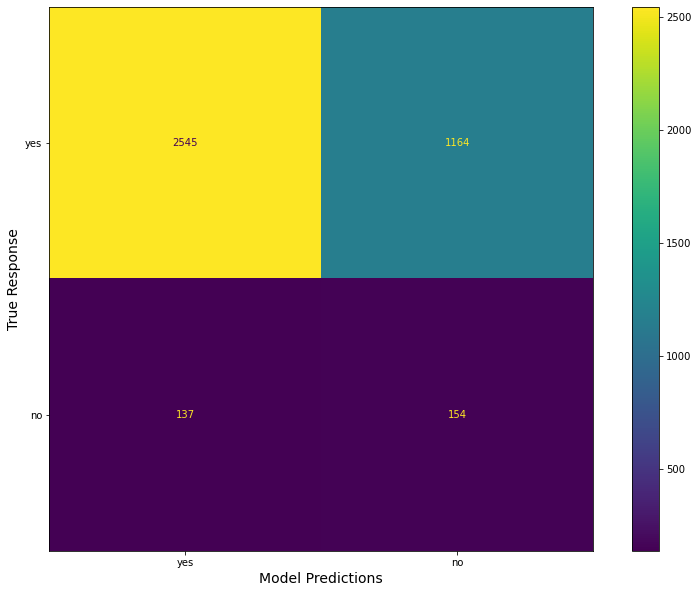

In [541]:
# Plot confusion matrix for test data
cm = confusion_matrix(y_test, y_pred.round())
ax = ConfusionMatrixDisplay(cm, display_labels=['yes','no']).plot()
ax.ax_.set_xlabel('Model Predictions', fontsize=14)
ax.ax_.set_ylabel('True Response', fontsize=14)
plt.show()

In [543]:
# Final Demographics/Financials/Contact model summary
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                66790
Model:                          Logit   Df Residuals:                    66780
Method:                           MLE   Df Model:                            9
Date:                Thu, 25 Aug 2022   Pseudo R-squ.:                 0.07907
Time:                        16:17:18   Log-Likelihood:                -42635.
converged:                       True   LL-Null:                       -46295.
Covariance Type:            nonrobust   LLR p-value:                     0.000
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               1.4908      0.027     55.698      0.000       1.438       1.543
contact_unknown    -1.2725      0.021    -59.750      0.000      -1.314      -1.231
marital_married    -0.3093      0.017    -18.169      0.000      -0.343      -0.276
month_aug          -1.1508      0.029    -40.062      0.000      -1.207      -1.094
housing            -0.4765      0.018    -26.771      0.000      -0.511      -0.442
month_jul          -0.8793      0.025    -35.853      0.000      -0.927      -0.831
month_nov          -0.8312      0.031    -26.986      0.000      -0.892      -0.771
job_blue-collar    -0.1442      0.021     -7.014      0.000      -0.184      -0.104
month_jan          -2.0818      0.067    -31.140      0.000      -2.213      -1.951
30-60              -0.3844      0.025    -15.406      0.000      -0.433      -0.335
===================================================================================
"""

## Full Dataset Model ##

### Preprocess data ###

In [628]:
# Read in the rawData
rawData = pd.read_csv('term-deposit-marketing-2020.csv')

# Separate data in independent (features) and dependent (target) datasets
features = rawData.copy()
target = features.pop('y')

# Replace target 'yes'/'no' with 1/0
target.replace({'yes':1,'no':0}, inplace=True)

# Split data initially to form a validation and test dataset
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.10, random_state=10)

# Reset index after train_test_split
x_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
x_test.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

In [629]:
# Replace binary columns with 1/0 and One-Hot Encode categorical columns
cols = ['default', 'housing', 'loan', 'marital', 'education', 'job', 'contact', 'month', 'day']
enc = OneHotEncoder(sparse=False, dtype=int, handle_unknown='error', drop='if_binary')
encodedTrain = enc.fit_transform(x_train[cols]) # Fit only on the training data
encodedTest = enc.transform(x_test[cols])

# Construct encoded names for One-Hot columns
encNames = enc.get_feature_names()
for index, item in enumerate(encNames):
    tmp = item.split('_')[0].split('x')[1]
    if (item.split('_')[1] == 'yes'):
        encNames[index] = encNames[index].replace('x' + tmp + '_yes', cols[int(tmp)])
    else:
        encNames[index] = encNames[index].replace('x' + tmp, cols[int(tmp)])

encodedTrain = pd.DataFrame(encodedTrain, columns=encNames)
encodedTest = pd.DataFrame(encodedTest, columns=encNames)

# Merge encoded columns back into the dataset
x_train = x_train.drop(columns=cols)
x_train = pd.concat([x_train, encodedTrain], axis=1)
x_test = x_test.drop(columns=cols)
x_test = pd.concat([x_test, encodedTest], axis=1)

In [630]:
# Bin age to deal with outliers/group similar ranges 
for dataset in [x_train, x_test]:    
    dataset['<30'] = (dataset['age'] < 30).replace({True:1,False:0})
    dataset['30-60'] = ((dataset['age'] >= 30) & (dataset['age'] < 61)).replace({True:1,False:0})
    dataset['61+'] = (dataset['age'] >= 61).replace({True:1,False:0})

# Bin balance to deal with outliers/group similar ranges
for dataset in [x_train, x_test]:    
    dataset['<1000'] = (dataset['balance'] < 1000).replace({True:1,False:0})
    dataset['1000-20000'] = ((dataset['balance'] >= 1000) & (dataset['age'] < 20000)).replace({True:1,False:0})
    dataset['>20000'] = (dataset['balance'] >= 20000).replace({True:1,False:0})
    
# Bin day to deal with outliers/group similar ranges
#for dataset in [x_train, x_test]:    
#    dataset['BegMonth'] = (dataset['day'] < 5).replace({True:1,False:0})
#    dataset['MidMonth'] = ((dataset['day'] >= 5) & (dataset['day'] < 30)).replace({True:1,False:0})
#    dataset['LastDayMonth'] = (dataset['day'] >= 30).replace({True:1,False:0})

### Build Up Model ###

In [682]:
# Create 5 k-folds for model evaluation
kf = KFold(n_splits=5, random_state=30, shuffle=True)

# Add constants to the dataset (needed in statsmodels package)
x_train = sm.add_constant(x_train)

# Create a list to append models evaluation to
summaryTab = []

# Build-up model process, test each indep variable against response,
# choose best performing (ad-hoc process using combination of low AIC/BIC, 
# p-value and validation set scoring metrics)
# Then add that variable and repeat the process with the remaining variables
# Stop once the addition of extra variables doesn't add much to the solution (keep model simpler)
for col in x_train:
    #print (col)
    # features chosen in the final model
    useCols = ['const', 'duration', 'contact_unknown', 'month_mar', '30-60', '<30', 'month_oct',
               'month_jan']
    # features that begin to have convergence issues as the model is developed
    skipCols = ['61+', 'month_dec', '20000+'] 
    if (col in useCols): continue
    if (col in skipCols): continue
    #useCols.append(col)  ### comment this out when finished
    
    # Cross-validation loop
    cnt = 0
    for train_index, valid_index in kf.split(x_train):
        cur_x_train, cur_x_valid = x_train.iloc[train_index], x_train.iloc[valid_index]
        cur_y_train, cur_y_valid = y_train.iloc[train_index], y_train.iloc[valid_index]
        
        # Oversample the minority set in the training data
        oversample = SMOTE()
        x_train_ov, y_train_ov = oversample.fit_resample(cur_x_train, cur_y_train)
        
        # Train model
        logReg = sm.Logit(y_train_ov, x_train_ov[useCols])
        result = logReg.fit(disp=False)

        # Evaluate model on validation dataset
        y_pred = logReg.predict(result.params, exog=cur_x_valid[useCols])
    
        # Store model evaluation metrics to display below
        summaryTab.append([cnt, col, result.pvalues.max(), result.llf, result.aic, result.bic, 
                       recall_score(cur_y_valid,y_pred.round()),precision_score(cur_y_valid,y_pred.round()),
                       f1_score(cur_y_valid,y_pred.round()),accuracy_score(cur_y_valid,y_pred.round()),
                       balanced_accuracy_score(cur_y_valid,y_pred.round())])
        
        # Counter for fold number
        cnt = cnt + 1
        
    break   ### comment this in when finished to build final model
    
# Create summary table
tab = pd.DataFrame(summaryTab, columns=['fold', 'name', 'max_pvalue','llf', 'aic', 'bic', 'recall', 
                                        'precision', 'f1', 'accuracy', 'balanced accuracy'])

# Aggregate results across folds
aggs = {'llf': 'mean', 'max_pvalue': 'max', 'aic': 'mean', 'bic': 'mean', 'recall': 'mean', 
        'precision': 'mean', 'f1': 'mean', 'accuracy': 'mean', 'balanced accuracy': 'mean'}
tab = tab.groupby(by='name').agg(aggs)

# Display model evaluation results
tab.sort_values(by='aic', ascending=True)

/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:130: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,llf,max_pvalue,aic,bic,recall,precision,f1,accuracy,balanced accuracy
name,,,,,,,,,
age,-17161.050688,1.614227e-12,34338.101375,34409.191654,0.708118,0.361952,0.478962,0.888694,0.805436


In [688]:
# Build up model sequence summary (seq column tells order in which feature was added)
fullDatasetModel = pickle.load(open('fullDatasetModel.p','rb'))
fullDatasetModel.sort_values(by='seq')

,llf,max_pvalue,aic,bic,recall,precision,f1,accuracy,balanced accuracy,seq
duration,-24640.108390,0.000000e+00,49284.216780,49301.989349,0.738003,0.292128,0.418481,0.851806,0.799331,1.0
month_mar,-24456.770497,8.199535e-57,48919.540994,48946.199848,0.773740,0.300767,0.433087,0.853667,0.816810,2.0
30-60,-19778.921900,5.667477e-22,39567.843800,39612.275224,0.758439,0.298188,0.428012,0.853528,0.809683,3.0
<30,-17537.884079,1.670056e-20,35087.768159,35141.085867,0.700364,0.357007,0.472899,0.887222,0.801064,4.0
month_oct,-17505.029612,1.751471e-15,35024.059223,35086.263217,0.708868,0.359291,0.476828,0.887639,0.805212,5.0
month_jan,-17170.385742,1.308193e-13,34356.771484,34427.861762,0.707690,0.362108,0.479035,0.888806,0.805296,6.0


### Evaluate model on test data ###

In [691]:
finalCols = ['const', 'duration', 'contact_unknown', 'month_mar', '30-60', '<30', 'month_oct',
               'month_jan']

# Build final model
oversample = SMOTE()
x_train_ov, y_train_ov = oversample.fit_resample(x_train[finalCols], y_train)
logReg = sm.Logit(y_train_ov, x_train_ov)
result = logReg.fit(disp=False)

# Evaluate model on test dataset
x_test = sm.add_constant(x_test)
y_pred = logReg.predict(result.params, exog=x_test[finalCols])

print ('Recall:', recall_score(y_test,y_pred.round()))
print ('Precision:', precision_score(y_test,y_pred.round()))
print ('F1:', f1_score(y_test,y_pred.round()))
print ('Accuracy:', accuracy_score(y_test,y_pred.round()))

Recall: 0.6677966101694915
Precision: 0.32137030995106036
F1: 0.43392070484581496
Accuracy: 0.8715


/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:130: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


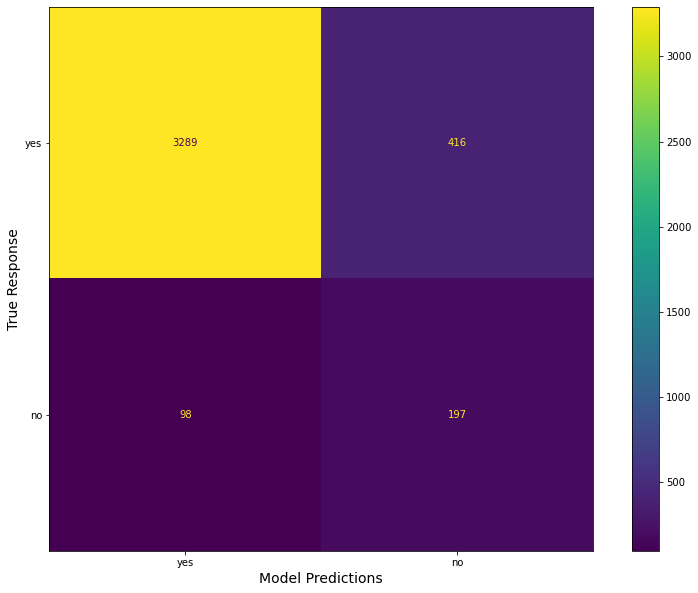

In [692]:
# Plot confusion matrix for test data
cm = confusion_matrix(y_test, y_pred.round())
ax = ConfusionMatrixDisplay(cm, display_labels=['yes','no']).plot()
ax.ax_.set_xlabel('Model Predictions', fontsize=14)
ax.ax_.set_ylabel('True Response', fontsize=14)
plt.show()

In [693]:
# Final Full Dataset model summary
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                66798
Model:                          Logit   Df Residuals:                    66790
Method:                           MLE   Df Model:                            7
Date:                Thu, 25 Aug 2022   Pseudo R-squ.:                  0.5020
Time:                        22:34:00   Log-Likelihood:                -23058.
converged:                       True   LL-Null:                       -46301.
Covariance Type:            nonrobust   LLR p-value:                     0.000
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               2.0764      0.093     22.379      0.000       1.895       2.258
duration            0.0062   5.41e-05    115.071      0.000       0.006       0.006
contact_unknown    -2.7269      0.043    -63.257      0.000      -2.811      -2.642
month_mar           1.8417      0.117     15.724      0.000       1.612       2.071
30-60              -4.3151      0.093    -46.312      0.000      -4.498      -4.132
<30                -4.4997      0.101    -44.654      0.000      -4.697      -4.302
month_oct           2.6471      0.286      9.268      0.000       2.087       3.207
month_jan          -4.4020      0.240    -18.330      0.000      -4.873      -3.931
===================================================================================
"""